# fit.kn2all.ipynb
- fitting kilonova observational data to the other models

In [40]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import sncosmo

In [41]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [42]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth

from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_lsst_bandwidth
lsstbdw = get_lsst_bandwidth()

- Fitting function

In [43]:
from scipy.optimize import curve_fit

def func(x, a):
	return a*x

# def calc_chisquare(obs, exp):
# 	return np.sum((obs-exp)**2/exp)

# def calc_redchisquare(obs, exp, dof):
# 	return calc_chisquare(obs, exp)/dof

def calc_chisquare(obs, exp, obserr):
	return np.sum((obs-exp)**2/obserr)

def calc_redchisquare(obs, exp, obserr, dof):
	return calc_chisquare(obs, exp, obserr)/dof

def calc_AIC(k, L):
	"""
	L : likelihood
	k : the number of free parameters
	"""
	AIC = 2*k-2*np.log(L)
	return AIC

def calc_AICc(AIC, k, n):
	"""
	n : the number of filters
	k : the number of free parameters
	"""
	AICc = AIC+(2*k*(k+1))/(n-k-1)
	return AICc

def calc_chisq_det(fobs, fobserr, fmdl):
	"""
	Chisquare calculcation for detection
	fobs     : the observed flux in the nth band
	fobsderr : the uncentainty of fobs
	fmdl     : the model flux
	"""
	chisq = ((fobs-fmdl)/fobserr)**2
	return chisq

def calc_chisq_nd(fobs, fobserr, fmdl, flim):
	"""
	Chisquare calculcation for non-detection
	fobs     : the observed flux in the nth band
	fobsderr : the uncentainty of fobs
	fmdl     : the model flux
	flim     : the upper limit of flux in the nth band
	"""
	from scipy import special
	chisq = -2*np.log(np.sqrt(np.pi/2)*fobserr*(1+special.erf((flim-fmdl)/(np.sqrt(2)*fobserr))))
	return chisq


def calc_mchisquare(fobs, fobserr, fmdl, flim):
	"""
	Modified chisquare
	"""
	mchisq = np.sum(calc_chisq_det(fobs, fobserr, fmdl))+np.sum(calc_chisq_nd(fobs, fobserr, fmdl, flim))
	return mchisq

def calc_l(AICc0, AICc1):
	l = np.exp(-0.5*(AICc0-np.array([AICc0, AICc1]).min()))
	return l

def calc_AICc_weight(AICc0, AICc1):
	"""
	l0 : standard
	w>0.99 : case 0 is 100 times more likey to be the best model than case 1
	"""
	l0 = calc_l(AICc0, AICc1)
	l1 = calc_l(AICc1, AICc1)
	w = l0/(l0+l1)
	return w


In [66]:
def extract_fnu_from_simulation(psimtbl):
	fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if 't' != filte]
	return fnuabs

def extract_fnu_anwr_from_observation(pobstbl):
	fnuabs_anwr = [(pobstbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in pobstbl.keys() if 'magabs' in filte]
	return fnuabs_anwr

def extract_fnu_from_observation(pobstbl):
	fnuobs = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuobs_' in filte]
	fnuobserr = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuerr_' in filte]
	return fnuobs, fnuobserr

def calc_colors(pobstbl, bd0, bd1, bd2):
	gr = (pobstbl[f'magobs_{bd0}']-pobstbl[f'magobs_{bd1}']).item()
	grerr = np.sqrt(
		(pobstbl[f'magerr_{bd0}']**2)+(pobstbl[f'magerr_{bd1}']**2)
	).item()
	ri = (pobstbl[f'magobs_{bd1}']-pobstbl[f'magobs_{bd2}']).item()
	rierr = np.sqrt(
		(pobstbl[f'magerr_{bd1}']**2)+(pobstbl[f'magerr_{bd2}']**2)
	).item()
	return gr, grerr, ri, rierr

def calc_chisq_all(fnuabs, popt, fnuobs, fnuobserr, dof):
	chisq = calc_chisquare(
		obs=fnuabs*popt,
		exp=fnuobs,
		obserr=fnuobserr,
		)

	rchisq = calc_redchisquare(
		obs=fnuabs*popt,
		exp=fnuobs,
		obserr=fnuobserr,
		dof=dof,
	)
	return chisq, rchisq

def fit_routine(knclrtbl, bd0, bd1, bd2, gr, grerr, ri, rierr, fnuobs0, fnuobserr0, fnuabs_anwr0, indx_det, t=None, verbose=True):
	#	Color tolerence
	if t == None:
		indx_clr = np.where(
			(knclrtbl[f"{bd0}-{bd1}"]>gr-grerr) &
			(knclrtbl[f"{bd0}-{bd1}"]<gr+grerr) &
			(knclrtbl[f"{bd1}-{bd2}"]>ri-rierr) &
			(knclrtbl[f"{bd1}-{bd2}"]<ri+rierr)
		)
	#	If t is not None
	else:
		indx_clr = np.where(
			(knclrtbl[f"{bd0}-{bd1}"]>gr-grerr) &
			(knclrtbl[f"{bd0}-{bd1}"]<gr+grerr) &
			(knclrtbl[f"{bd1}-{bd2}"]>ri-rierr) &
			(knclrtbl[f"{bd1}-{bd2}"]<ri+rierr) &
			(knclrtbl["t"]==t)
		)

	cmpmodels = knclrtbl['model name'][indx_clr]
	print(f"Comparison Models ({len(cmpmodels)})")
	cmptimes = knclrtbl['t'][indx_clr]

	if len(cmpmodels) > 0:
		# print(f"Compare model : {len(cmpmodels)}")
		cmpchisqarr = np.array([])
		cmprchisqarr = np.array([])
		cmppoptarr = np.array([])
		dofarr = np.array([])
		for nn, (cmpmdl, t_cmp) in enumerate(zip(cmpmodels, cmptimes)):
			cmptbl = ascii.read(cmpmdl)

			#	From psimtbl
			pcmptbl = cmptbl[(cmptbl['t']==t_cmp)]
			fnuabs = extract_fnu_from_simulation(pcmptbl)
			#	Detection (SNR>5)
			fnuabs = np.array(fnuabs)[indx_det]
			fnuobs = np.array(fnuobs0)[indx_det]
			fnuobserr = np.array(fnuobserr0)[indx_det]
			fnuabs_anwr = np.array(fnuabs_anwr0)[indx_det]

			#	not NaN value
			indx_avail = np.array([i for i, val in enumerate(fnuabs) if not(np.isnan(val))])

			fnuabs = fnuabs[indx_avail]
			fnuobs = fnuobs[indx_avail]
			fnuobserr = fnuobserr[indx_avail]
			fnuabs_anwr = fnuabs_anwr[indx_avail]

			#	Fitting
			popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
			dof = len(fnuobs) - 1
			chisq, rchisq = calc_chisq_all(fnuabs, popt, fnuobs, fnuobserr, dof)

			#	Save the result
			cmpchisqarr = np.append(cmpchisqarr, chisq)
			cmprchisqarr = np.append(cmprchisqarr, rchisq)
			cmppoptarr = np.append(cmppoptarr, popt[0])
			dofarr = np.append(dofarr, dof)

		#	Find best-fit
		cmpchisqmin = cmpchisqarr.min()
		cmprchisq = cmprchisqarr.min()
		indx_chisqbest = np.where(cmpchisqarr==cmpchisqmin)
		cmpbestmdl = cmpmodels[indx_chisqbest][0]
		cmpbestt = cmptimes[indx_chisqbest][0]
		cmppopt = cmppoptarr[indx_chisqbest][0]
		cmpdof = dofarr[indx_chisqbest][0]
	#	No point to fit
	else:
		cmpchisqmin = None
		cmprchisq = None
		cmpdof = 0
		cmpbestmdl = None
		cmpbestt = None
		cmppopt = None

	if verbose:
		print(f"-"*40)
		print(f"Result")
		print(f"-"*40)
		print(f"Best Model : {os.path.basename(cmpbestmdl)} (t={cmpbestt:1.1f}d)")
		print(f"Min. Chisq : {cmpchisqmin:1.3f}")
		print(f"a          : {cmppopt:1.3f}")
	return cmpchisqmin, cmprchisq, cmpdof, cmpbestmdl, cmpbestt, cmppopt, cmpmodels

In [45]:
# magoffset = -2.5*np.log10(54)
magoffset = -4.3
d = 40
print(f"Apply magnitude offset : {magoffset:1.3f} mag")
print(f"Distance               : {d} Mpc")

Apply magnitude offset : -4.300 mag
Distance               : 40 Mpc


In [46]:
obsphtlist = sorted(glob.glob(f"../5.result/kn_sim_cube_obs/lsst_30s_iter10_{d}Mpc/Run*.ecsv"))
cmpphtlist = sorted(glob.glob('../3.table/sn_sim_sncosmo_synphot/*_lsst.ecsv'))+sorted(glob.glob(f'../3.table/asteroid_sim_smass_synphot/*_lsst.ecsv'))

print(f'KN obs. data    : {len(obsphtlist)}')
print(f'Other sim. data : {len(cmpphtlist)}')

KN obs. data    : 6300
Other sim. data : 53


- Fix single case

In [47]:
ii = -8
jj = 0

obspht = obsphtlist[ii]
cmppht = cmpphtlist[jj]

print(f"[{ii}] Input obs   : {os.path.basename(obspht)}")
print(f"[{jj}] Comp. Model : {os.path.basename(cmppht)}")

#	Read tables
obstbl = ascii.read(obspht)
cmptbl = ascii.read(cmppht)

[-8] Input obs   : Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.15_angle90_synphot_lsst_obs_d40_iter10.lsst.ecsv
[0] Comp. Model : hsiao_v3.0_type_Ia_sn_z0.0001_synphot_lsst.ecsv


In [48]:
t = 1.0
seed = 1
t_cmp = 10

#	Part obs. Table
pobstbl = obstbl[
	(obstbl['t']==t) &
	(obstbl['seed']==seed)
]

pcmptbl = cmptbl[
	#	Supernova Type Ia
	(cmptbl['t']==t_cmp)
]

fnuabs = extract_fnu_from_simulation(pcmptbl)
fnuabs_anwr = extract_fnu_anwr_from_observation(pobstbl)
fnuobs, fnuobserr = extract_fnu_from_observation(pobstbl)

In [49]:
popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr, fnuobs, sigma=fnuobserr, absolute_sigma=True,)

In [50]:
dof = len(fnuobs) - 1

chisq = calc_chisquare(
	obs=fnuabs*popt,
	exp=fnuobs,
	obserr=fnuobserr,
	)

rchisq = calc_redchisquare(
	obs=fnuabs*popt,
	exp=fnuobs,
	obserr=fnuobserr,
	dof=dof,
)

chisq_anwr = calc_chisquare(
	obs=fnuabs_anwr*popt_anwr,
	exp=fnuobs,
	obserr=fnuobserr,
	)

rchisq_anwr = calc_redchisquare(
	obs=fnuabs_anwr*popt_anwr,
	exp=fnuobs,
	obserr=fnuobserr,
	dof=dof,
	)

print('-'*40)
print('Model comp.')
print('-'*40)
print(f"DoF       : {dof}")
print(f"Chisq     : {chisq:1.3f}")
print(f"Red.chisq : {rchisq:1.3f}")
print('-'*40)
print('Answer')
print('-'*40)
print(f"Chisq     : {chisq_anwr:1.3f}")
print(f"Red.chisq : {rchisq_anwr:1.3f}")

----------------------------------------
Model comp.
----------------------------------------
DoF       : 5
Chisq     : 5467.356
Red.chisq : 1093.471
----------------------------------------
Answer
----------------------------------------
Chisq     : 19.598
Red.chisq : 3.920


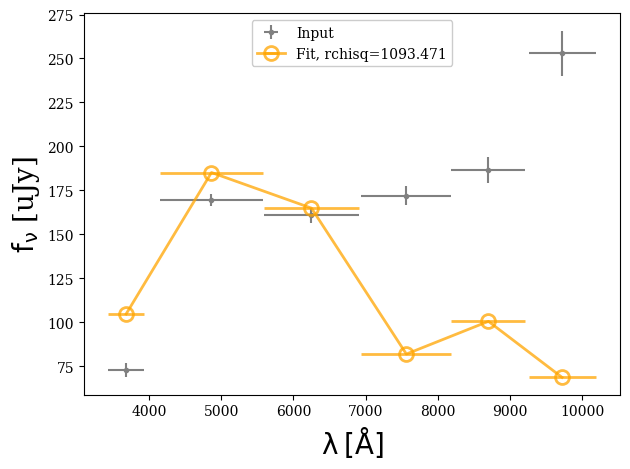

In [51]:
#	Med-bands
bdw = lsstbdw
lam = lsstlam

plt.errorbar(lam, fnuobs, xerr=bdw/2, yerr=fnuobserr, marker='.', mec='grey', mfc='grey', c='grey', ls='none', label='Input')
plt.errorbar(lam, fnuabs*popt, xerr=bdw/2, marker='o', ms=10, mew=2, mec='orange', mfc='none', c='orange', ls='-', lw=2, alpha=0.75, label=f'Fit, rchisq={rchisq:1.3f}')

plt.xlabel(r'$\rm \lambda\:[\AA]$')
plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
plt.legend(loc='upper center', framealpha=1.0)
plt.tight_layout()

- plot

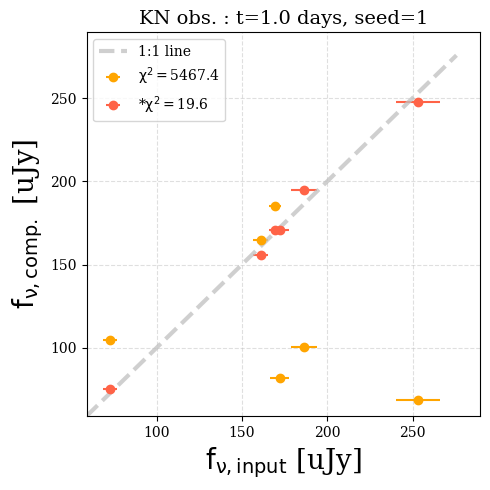

In [52]:
fig = plt.figure(figsize=(5, 5))
plt.title(f"KN obs. : t={t:1.1f} days, seed={seed}")
plt.errorbar(fnuobs, fnuabs*popt, xerr=fnuobserr, ls='none', c='orange', marker='o', label=r'$\rm \chi^{2}=$'+f'{chisq:1.1f}')
plt.errorbar(fnuobs, fnuabs_anwr*popt_anwr, xerr=fnuobserr, ls='none', c='tomato', marker='o', label=r'*$\rm \chi^{2}=$'+f'{chisq_anwr:1.1f}')

xl, xr = plt.xlim()
plt.xlim([xl, xr*1.05])
plt.ylim([xl, xr*1.05])

plt.plot([xl, xr*1.0], [xl, xr*1.0], ls='--', color='silver', lw=3, label='1:1 line', alpha=0.75)
plt.legend()
plt.xlabel(r'$\rm f_{\nu, input}$ [uJy]')
plt.ylabel(r'$\rm f_{\nu, comp.}$ [uJy]')
plt.tight_layout()
plt.grid('both', ls='--', c='silver', alpha=0.5)

# Make color table

In [53]:
# comparison.models.color.med.ecsv   kn.sim_cube.color.med.ecsv
tag = 'lsst'
cmpclrtbl = ascii.read(f"../3.table/comparison.models.color.{tag}.ecsv",)
knclrtbl = ascii.read(f"../3.table/kn.sim_cube.color.{tag}.ecsv",)

bd0, bd1, bd2 = 'g', 'r', 'i'
# colortol = 0.25
print('-'*40)
print(f"{tag} Colors")
print('-'*40)
print(f"Band 0    : {bd0}")
print(f"Band 1    : {bd1}")
print(f"Band 2    : {bd2}")
# print(f"Color Tol : +/-{colortol}")

----------------------------------------
lsst Colors
----------------------------------------
Band 0    : g
Band 1    : r
Band 2    : i


# Bulk

In [54]:
times = np.unique(obstbl['t'])
#	Time index
# indx_time = np.array([0, 8, 16, 24, 29, 32, 35, 37])
indx_time = np.array([0, 8, 16, 24, 29, 32])
ntimes = times[indx_time]
print(f"Times : {list(times[indx_time])} days")

Times : [0.125, 0.25, 0.5, 1.0, 1.542, 2.0] days


- select similar color

# Color selection

## Test

In [33]:
oo = -8
cc = 0
seed = 0

tablelist = []

obspht = obsphtlist[oo]
for oo, obspht in enumerate(obsphtlist):
	print(f"[{oo+1}/{len(obsphtlist)}] {os.path.basename(obspht)}"+" "*10, end='\r')
	# cmppht = cmpphtlist[cc]

	obstbl = ascii.read(obspht)
	obstbl = obstbl[obstbl['seed']==seed]

	seeds = np.unique(obstbl['seed'])
	times = np.unique(obstbl['t'])

	#	Save the fitting result
	tmptbl = Table()
	tmptbl['seed'] = [seed]*len(ntimes)
	tmptbl['obs'] = os.path.basename(obspht)
	tmptbl['t'] = times[indx_time]
	tmptbl[f'{bd0}-{bd1}'] = 0.0
	tmptbl[f'({bd0}-{bd1})err'] = 0.0
	tmptbl[f'{bd1}-{bd2}'] = 0.0
	tmptbl[f'({bd1}-{bd2})err'] = 0.0

	##	Empty Table
	###	KN
	tmptbl['kn_bestfit'] = ' '*200
	tmptbl['kn_t'] = 0.0
	tmptbl['kn_compare_models'] = 0
	tmptbl['kn_chisq'] = 0.0
	tmptbl['kn_rchisq'] = 0.0
	tmptbl['kn_popt'] = 0.0
	tmptbl['kn_dof'] = 0
	###	Comparison
	tmptbl['cmp_bestfit'] = ' '*200
	tmptbl['cmp_t'] = 0.0
	tmptbl['cmp_compare_models'] = 0
	tmptbl['cmp_chisq'] = 0.0
	tmptbl['cmp_rchisq'] = 0.0
	tmptbl['cmp_popt'] = 0.0
	tmptbl['cmp_dof'] = 0

	# tmptbl['colorcut'] = 
	###
	tmptbl['identification'] = False

	# tt = 0
	# t = ntimes[tt]
	for tt, t in enumerate(ntimes):
		pobstbl = obstbl[(obstbl['t']==t)]

		gsnr = pobstbl[f'snr_{bd0}'].item()
		rsnr = pobstbl[f'snr_{bd1}'].item()
		isnr = pobstbl[f'snr_{bd2}'].item()
	
		if (gsnr >= 5) and (rsnr >= 5) and (isnr >= 5):

			#	Detection check
			snrarr = np.array([pobstbl[key].item() for key in pobstbl.keys() if 'snr' in key])
			indx_det = np.where(snrarr >= 5)

			#	Fitting for the truth
			fnuabs_anwr0 = extract_fnu_anwr_from_observation(pobstbl)
			fnuobs0, fnuobserr0 = extract_fnu_from_observation(pobstbl)
			popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr0, fnuobs0, sigma=fnuobserr, absolute_sigma=True,)

			gr, grerr, ri, rierr = calc_colors(pobstbl, bd0, bd1, bd2)
			# print(f"{bd0}-{bd1} : {gr:1.3f} +/- {grerr:1.3f}")
			# print(f"{bd1}-{bd2} : {ri:1.3f} +/- {rierr:1.3f}")
			tmptbl[f'{bd0}-{bd1}'][tt] = gr
			tmptbl[f'({bd0}-{bd1})err'][tt] = grerr
			tmptbl[f'{bd1}-{bd2}'][tt] = ri
			tmptbl[f'({bd1}-{bd2})err'][tt] = rierr
			#	Other transients
			cmpchisqmin, cmprchisq, cmpdof, cmpbestmdl, cmpbestt, cmppopt, cmpmodels = fit_routine(cmpclrtbl, bd0, bd1, bd2, gr, grerr, ri, rierr, fnuobs0, fnuobserr0, fnuabs_anwr0, indx_det, t=None, verbose=False)

			if cmpbestmdl != None:
				tmptbl['cmp_bestfit'][tt] = os.path.basename(cmpbestmdl)
			else:
				tmptbl['cmp_bestfit'][tt] = None

			tmptbl['cmp_t'][tt] = cmpbestt
			tmptbl['cmp_compare_models'] = len(cmpmodels)
			tmptbl['cmp_chisq'][tt] = cmpchisqmin
			tmptbl['cmp_rchisq'][tt] = cmprchisq
			tmptbl['cmp_popt'][tt] = cmppopt
			tmptbl['cmp_dof'][tt] = cmpdof

			#	Kilonovae
			cmpchisqmin, cmprchisq, cmpdof, cmpbestmdl, cmpbestt, cmppopt, cmpmodels = fit_routine(knclrtbl, bd0, bd1, bd2, gr, grerr, ri, rierr, fnuobs0, fnuobserr0, fnuabs_anwr0, indx_det, t=t, verbose=False)

			if cmpbestmdl != None:
				tmptbl['kn_bestfit'][tt] = os.path.basename(cmpbestmdl)
			else:
				tmptbl['kn_bestfit'][tt] = None

			tmptbl['kn_t'][tt] = cmpbestt
			tmptbl['kn_compare_models'] = len(cmpmodels)
			tmptbl['kn_chisq'][tt] = cmpchisqmin
			tmptbl['kn_rchisq'][tt] = cmprchisq
			tmptbl['kn_popt'][tt] = cmppopt
			tmptbl['kn_dof'][tt] = cmpdof


	tablelist.append(tmptbl)

fitbl = vstack(tablelist)
for ii in range(len(fitbl)):
	pfitbl = fitbl[ii]
	if pfitbl['kn_rchisq'].item() < pfitbl['cmp_rchisq'].item():
		fitbl['identification'][ii] = True


In [34]:
fitbl.write('../5.result/fit_kn2all/lsst/fit.fits', format='fits')
fitbl

seed,obs,t,g-r,(g-r)err,r-i,(r-i)err,kn_bestfit,kn_t,kn_compare_models,kn_chisq,kn_rchisq,kn_popt,kn_dof,cmp_bestfit,cmp_t,cmp_compare_models,cmp_chisq,cmp_rchisq,cmp_popt,cmp_dof,identification
,,d,,,,,,,,,,,,,,,,,,,
int64,str107,float64,float64,float64,float64,float64,str200,float64,int64,float64,float64,float64,int64,str200,float64,int64,float64,float64,float64,int64,bool
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.125,0.0,0.0,0.0,0.0,,0.0,267,0.0,0.0,0.0,0,,0.0,16,0.0,0.0,0.0,0,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.25,0.262462545211573,0.12205503138085355,-0.1532002751974666,0.15060379070480906,Run_TS_dyn_all_lanth_wind1_all_md0.1_vd0.3_mw0.03_vw0.3_angle180_synphot_lsst.ecsv,0.25,267,1.3142939716171367,0.32857349290428417,5.033837276221477e-14,4,v19-2009ip-corr_v1.0_type_IIn_sn_z0.001_synphot_lsst.ecsv,30.0,16,0.8120279017968068,0.2030069754492017,5.0784314804293134e-05,4,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.5,-0.05682223376942375,0.08311059551847032,0.08236380344346017,0.10449351139788024,Run_TP_dyn_all_lanth_wind1_all_md0.03_vd0.3_mw0.01_vw0.15_angle60_synphot_lsst.ecsv,0.5,267,1.233436952003863,0.24668739040077262,5.920044544097892e-13,5,v19-2007pk-corr_v1.0_type_IIn_sn_z0.1_synphot_lsst.ecsv,5.0,16,2.983126731097946,0.5966253462195892,0.5132082990536271,5,True
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,1.0,1.1732383617187807,0.1627151106148356,0.33269683493540825,0.13908254139432025,Run_TP_dyn_all_lanth_wind1_all_md0.1_vd0.05_mw0.003_vw0.3_angle60_synphot_lsst.ecsv,1.0,267,1.6922238210807883,0.42305595527019707,9.97012148556033e-13,4,v19-2004gt-corr_v1.0_type_Ic_sn_z0.1_synphot_lsst.ecsv,40.0,16,11.374996524363114,2.8437491310907785,0.37516410765423513,4,True
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,1.542,0.0,0.0,0.0,0.0,,0.0,267,0.0,0.0,0.0,0,,0.0,16,0.0,0.0,0.0,0,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,2.0,0.0,0.0,0.0,0.0,,0.0,267,0.0,0.0,0.0,0,,0.0,16,0.0,0.0,0.0,0,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.125,0.0,0.0,0.0,0.0,,0.0,136,0.0,0.0,0.0,0,,0.0,39,0.0,0.0,0.0,0,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.25,0.11928416380614593,0.11551972746911543,-0.16444100461340483,0.1478558102492556,Run_TS_dyn_all_lanth_wind1_all_md0.003_vd0.15_mw0.03_vw0.05_angle0_synphot_lsst.ecsv,0.25,136,0.09566563825444871,0.023916409563612177,7.178566079489055e-13,4,v19-2007pk-corr_v1.0_type_IIn_sn_z0.0001_synphot_lsst.ecsv,10.0,39,1.5008081763910572,0.3752020440977643,2.815069214948893e-07,4,True


In [55]:
len(fitbl) == len(ntimes)*len(obsphtlist)

True

In [37]:
# for mdl in np.unique(fitbl['obs']):
# 	pfitbl = fitbl[fitbl['obs']==mdl]

truetbl = fitbl[fitbl['identification'] == True]
falsetbl = fitbl[fitbl['identification'] == False]

true, false = len(truetbl), len(falsetbl)
total = true+false

tfration = true/total

print(tfration)

0.39830687830687833


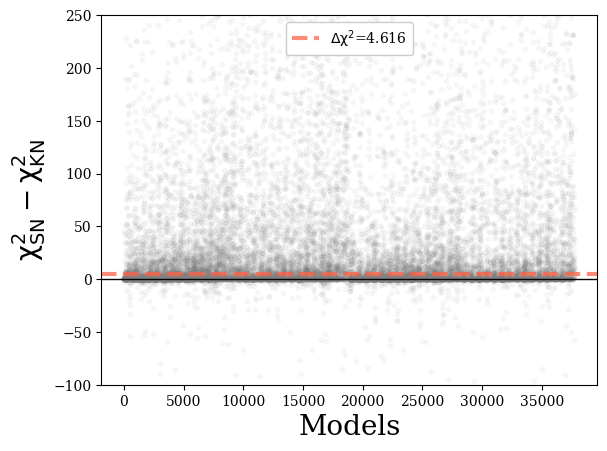

In [39]:
plt.plot(fitbl['cmp_rchisq']-fitbl['kn_rchisq'], marker='.', c='grey', ls='none', alpha=0.05)
# plt.hexbin(np.arange(len(fitbl)), fitbl['cmp_rchisq']-fitbl['kn_rchisq'],)

delchisqs = fitbl['cmp_rchisq']-fitbl['kn_rchisq']
delchisq = np.median([val for val in delchisqs if ~np.isnan(val)])

plt.axhline(delchisq, ls='--', c='tomato', lw=3, alpha=0.75, label=r"$\rm \Delta{\chi^2}$"+f'={delchisq:1.3f}')
plt.axhline(y=0, ls='-', c='k', lw=1.0, alpha=1.0,)

plt.ylim(-100, 250)
plt.xlabel('Models')
plt.ylabel(r'$\rm \chi^{2}_{SN}-\chi^{2}_{KN}$')
plt.legend(loc='upper center', framealpha=1.0)

In [73]:
oo = -8
cc = 0
seed = 0

tablelist = []

obspht = obsphtlist[oo]
obspht = f'../5.result/kn_sim_cube_obs/lsst_30s_iter10_{d}Mpc/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv'

# print(f"[{oo+1}/{len(obsphtlist)}] {os.path.basename(obspht)}"+" "*10, end='\r')
# cmppht = cmpphtlist[cc]

obstbl = ascii.read(obspht)
obstbl = obstbl[obstbl['seed']==seed]

seeds = np.unique(obstbl['seed'])
times = np.unique(obstbl['t'])

#	Save the fitting result
tmptbl = Table()
tmptbl['seed'] = [seed]*len(ntimes)
tmptbl['obs'] = os.path.basename(obspht)
tmptbl['t'] = times[indx_time]
tmptbl[f'{bd0}-{bd1}'] = 0.0
tmptbl[f'({bd0}-{bd1})err'] = 0.0
tmptbl[f'{bd1}-{bd2}'] = 0.0
tmptbl[f'({bd1}-{bd2})err'] = 0.0

##	Empty Table
###	KN
tmptbl['kn_bestfit'] = ' '*200
tmptbl['kn_t'] = 0.0
tmptbl['kn_compare_models'] = 0
tmptbl['kn_chisq'] = 0.0
tmptbl['kn_rchisq'] = 0.0
tmptbl['kn_popt'] = 0.0
tmptbl['kn_dof'] = 0
###	Comparison
tmptbl['cmp_bestfit'] = ' '*200
tmptbl['cmp_t'] = 0.0
tmptbl['cmp_compare_models'] = 0
tmptbl['cmp_chisq'] = 0.0
tmptbl['cmp_rchisq'] = 0.0
tmptbl['cmp_popt'] = 0.0
tmptbl['cmp_dof'] = 0

# tmptbl['colorcut'] = 
###
tmptbl['identification'] = False

# tt = 0
# t = ntimes[tt]
for tt, t in enumerate(ntimes):
	print(f"{os.path.basename(obspht)} : t={t}d")
	pobstbl = obstbl[(obstbl['t']==t)]

	gsnr = pobstbl[f'snr_{bd0}'].item()
	rsnr = pobstbl[f'snr_{bd1}'].item()
	isnr = pobstbl[f'snr_{bd2}'].item()

	if (gsnr >= 5) and (rsnr >= 5) and (isnr >= 5):

		#	Detection check
		snrarr = np.array([pobstbl[key].item() for key in pobstbl.keys() if 'snr' in key])
		indx_det = np.where(snrarr >= 5)

		#	Fitting for the truth
		fnuabs_anwr0 = extract_fnu_anwr_from_observation(pobstbl)
		fnuobs0, fnuobserr0 = extract_fnu_from_observation(pobstbl)
		popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr0, fnuobs0, sigma=fnuobserr, absolute_sigma=True,)

		gr, grerr, ri, rierr = calc_colors(pobstbl, bd0, bd1, bd2)
		# print(f"{bd0}-{bd1} : {gr:1.3f} +/- {grerr:1.3f}")
		# print(f"{bd1}-{bd2} : {ri:1.3f} +/- {rierr:1.3f}")
		tmptbl[f'{bd0}-{bd1}'][tt] = gr
		tmptbl[f'({bd0}-{bd1})err'][tt] = grerr
		tmptbl[f'{bd1}-{bd2}'][tt] = ri
		tmptbl[f'({bd1}-{bd2})err'][tt] = rierr
		#	Other transients
		print('Other transients')
		cmpchisqmin, cmprchisq, cmpdof, cmpbestmdl, cmpbestt, cmppopt, cmpmodels = fit_routine(cmpclrtbl, bd0, bd1, bd2, gr, grerr, ri, rierr, fnuobs0, fnuobserr0, fnuabs_anwr0, indx_det, t=None, verbose=False)

		if cmpbestmdl != None:
			tmptbl['cmp_bestfit'][tt] = os.path.basename(cmpbestmdl)
		else:
			tmptbl['cmp_bestfit'][tt] = None
			# print(cmpmodels)

		tmptbl['cmp_t'][tt] = cmpbestt
		if len(cmpmodels) > 0:
			tmptbl['cmp_compare_models'][tt] = len(cmpmodels)
		else:
			print(f"Empty models : {len(cmpmodels)}")
			tmptbl['cmp_compare_models'][tt] = 0.0
		tmptbl['cmp_chisq'][tt] = cmpchisqmin
		tmptbl['cmp_rchisq'][tt] = cmprchisq
		tmptbl['cmp_popt'][tt] = cmppopt
		tmptbl['cmp_dof'][tt] = cmpdof

		#	Kilonovae
		print('KNe')
		cmpchisqmin, cmprchisq, cmpdof, cmpbestmdl, cmpbestt, cmppopt, cmpmodels = fit_routine(knclrtbl, bd0, bd1, bd2, gr, grerr, ri, rierr, fnuobs0, fnuobserr0, fnuabs_anwr0, indx_det, t=t, verbose=False)

		if cmpbestmdl != None:
			tmptbl['kn_bestfit'][tt] = os.path.basename(cmpbestmdl)
		else:
			tmptbl['kn_bestfit'][tt] = None

		tmptbl['kn_t'][tt] = cmpbestt
		tmptbl['kn_compare_models'][tt] = len(cmpmodels)
		tmptbl['kn_chisq'][tt] = cmpchisqmin
		tmptbl['kn_rchisq'][tt] = cmprchisq
		tmptbl['kn_popt'][tt] = cmppopt
		tmptbl['kn_dof'][tt] = cmpdof


tablelist.append(tmptbl)

Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv : t=0.125d
Other transients
Comparison Models (9)
KNe
Comparison Models (886)
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv : t=0.25d
Other transients
Comparison Models (0)
Empty models : 0
KNe
Comparison Models (19)
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv : t=0.5d
Other transients
Comparison Models (12)
KNe
Comparison Models (189)
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv : t=1.0d
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv : t=1.542d
Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv : t=2.0d


In [74]:
tmptbl

seed,obs,t,g-r,(g-r)err,r-i,(r-i)err,kn_bestfit,kn_t,kn_compare_models,kn_chisq,kn_rchisq,kn_popt,kn_dof,cmp_bestfit,cmp_t,cmp_compare_models,cmp_chisq,cmp_rchisq,cmp_popt,cmp_dof,identification
,,d,,,,,,,,,,,,,,,,,,,
int64,str105,float64,float64,float64,float64,float64,str200,float64,int64,float64,float64,float64,int64,str200,float64,int64,float64,float64,float64,int64,bool
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.125,-0.3493726667564978,0.10078684893353831,-0.44539964110951047,0.1555244889865554,Run_TP_dyn_all_lanth_wind1_all_md0.03_vd0.15_mw0.001_vw0.3_angle0_synphot_lsst.ecsv,0.125,886,0.27045371821840614,0.09015123940613538,1.7126126790438017e-12,3,nugent-sn2l_v1.2_type_IIL_sn_z0.0001_synphot_lsst.ecsv,-5.0,9,20.21435551666972,6.7381185055565735,6382.807382909734,3,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.25,-0.3085771922423284,0.08634004784128707,-0.8612337072093794,0.14014179114943567,Run_TP_dyn_all_lanth_wind1_all_md0.1_vd0.15_mw0.01_vw0.3_angle0_synphot_lsst.ecsv,0.25,19,13.197753194535485,3.2994382986338713,4.124971240874674e-13,4,None,nan,0,nan,nan,nan,0,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.5,0.4862821987526438,0.10007748657972469,0.17630325280551418,0.10503247265268294,Run_TS_dyn_all_lanth_wind1_all_md0.001_vd0.3_mw0.01_vw0.15_angle120_synphot_lsst.ecsv,0.5,189,1.0932173370458644,0.2733043342614661,1.0198395061642452e-12,4,v19-1999em-corr_v1.0_type_IIP_sn_z0.1_synphot_lsst.ecsv,25.0,12,1.522007245044418,0.3805018112611045,0.4549034221994767,4,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,1.0,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,1.542,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,2.0,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False
